This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset.

In [ ]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2022-12-10 04:01:19--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2022-12-10 04:01:19 (23.2 MB/s) - ‘mini_classes.txt’ saved [760/760]



Read the classes names

In [ ]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Dowload the dataset
Loop over the classes and download the currospondent data



In [ ]:
!mkdir data


In [ ]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports


In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data
Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.


In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train) )

320000


Show some random data

wristwatch


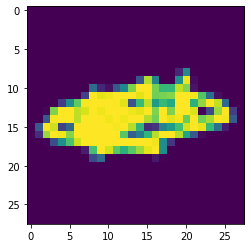

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [ ]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(100, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Training 

In [ ]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
1125/1125 - 273s - loss: 0.8727 - top_k_categorical_accuracy: 0.9312 - val_loss: 0.9303 - val_top_k_categorical_accuracy: 0.9262 - 273s/epoch - 243ms/step
Epoch 2/5
1125/1125 - 255s - loss: 0.8391 - top_k_categorical_accuracy: 0.9348 - val_loss: 0.9121 - val_top_k_categorical_accuracy: 0.9270 - 255s/epoch - 227ms/step
Epoch 3/5
1125/1125 - 236s - loss: 0.8086 - top_k_categorical_accuracy: 0.9374 - val_loss: 0.8967 - val_top_k_categorical_accuracy: 0.9295 - 236s/epoch - 210ms/step
Epoch 4/5
1125/1125 - 227s - loss: 0.7840 - top_k_categorical_accuracy: 0.9395 - val_loss: 0.8931 - val_top_k_categorical_accuracy: 0.9288 - 227s/epoch - 202ms/step
Epoch 5/5
1125/1125 - 234s - loss: 0.7643 - top_k_categorical_accuracy: 0.9415 - val_loss: 0.8792 - val_top_k_categorical_accuracy: 0.9298 - 234s/epoch - 208ms/step


# Testing

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.75%


# Inference

1/1 [==============================] - 0s 111ms/step
['airplane', 'cat', 'bird']


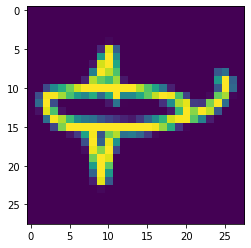

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:3]
latex = [class_names[x] for x in ind]
print(latex)

# Store classes

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Store TensorFlowJS

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 1.8 MB/s 
     |████████████████████████████████| 40 kB 5.6 MB/s 
     |████████████████████████████████| 16.2 MB 18.3 MB/s 
     |████████████████████████████████| 588.3 MB 17 kB/s 
     |████████████████████████████████| 197 kB 63.3 MB/s 
     |████████████████████████████████| 237 kB 46.7 MB/s 
     |████████████████████████████████| 66 kB 4.5 MB/s 
     |████████████████████████████████| 8.3 MB 36.7 MB/s 
     |████████████████████████████████| 154 kB 55.9 MB/s 
     |████████████████████████████████| 51 kB 5.3 MB/s 
     |████████████████████████████████| 6.0 MB 39.9 MB/s 
     |████████████████████████████████| 1.7 MB 43.3 MB/s 
     |████████████████████████████████| 439 kB 74.3 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator

# Save model

In [ ]:
model.save('keras.h5')

In [ ]:
model_save_name = 'keras.h5'

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2022-12-10 05:25:52.304280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-10 05:25:52.304559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-10 05:25:52.304590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Zip and Dowload

In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>